<a href="https://colab.research.google.com/github/BartBennett/SimStudent/blob/main/ED%20three%20level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import matplotlib.pyplot as plt

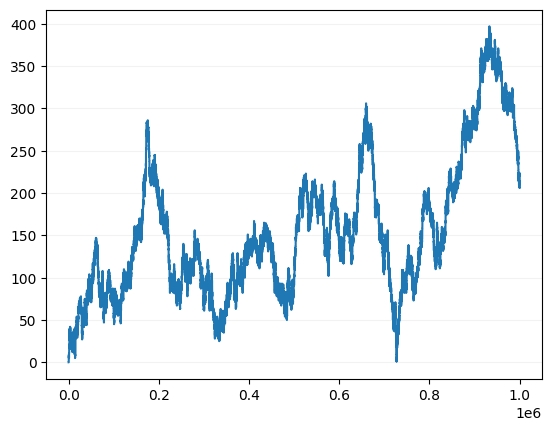

In [34]:
def arrival(ID):
    number_in[Registrar] += 1
    patients.append(patient(ID, sim_time, 0, 0))
    event_queue.append(event(sim_time + np.random.exponential(15.0), "Arrival", "Registrar", ID+1))
    if number_in[Registrar] <= servers[Registrar]:
        #print("Time: ", sim_time, " Arrival with immediate registration: ", ID)
        event_queue.append(event(sim_time + np.random.uniform(4,6), "Departure", "Registrar", ID))
    else:
        #print("Time: ", sim_time, " Arrival, waiting registrar: ", ID)
        queues[Registrar].append(ID)
        
def departure(server, ID):
    #Disposition of person completing process
    idx = server_names.index(server)
    number_in[idx] -= 1
    #print("Time: ", sim_time, " Patient ", ID, " completed ", server_names[idx])
    if idx < ED_bed:
        number_in[idx+1] += 1
        if number_in[idx+1] <= servers[idx+1]:
            next_server = server_names[idx+1]
            #print("Time: ", sim_time, " Patient ", ID, " immediate service with ", next_server)
            event_queue.append(event(sim_time + service_time(next_server), "Departure", next_server, ID))
            if idx+1 == ED_bed:
                patients[ID].bed_time = sim_time
        else:
            #print("Time: ", sim_time, " Patient ", ID, " waiting for ", server_names[idx+1])
            queues[idx].append(ID)
    else:
          #print("Time: ", sim_time, " Patient ", ID, " released")
          patients[ID].service_time = sim_time
    #Disposition of resource
    if number_in[idx] >= servers[idx]:
        next_ID = queues[idx][0]
        #print("Time: ", sim_time, " server ", server, " now serving patient ", next_ID)
        event_queue.append(event(sim_time + service_time(server), "Departure", server, next_ID))
        del queues[idx][0]
        if server == "ED_bed":
            waiting_for_bed.append(len(queues[idx]))
            time_for_bed.append(sim_time)
 
def service_time(process):
    match process:
        case "Registrar":
            return np.random.uniform(4.0, 6.0)
        case "Triage_nurse":
            return np.random.exponential(15.0)
        case "ED_bed":  
            return 60.0 + np.random.exponential(30.0) + \
                np.random.exponential(45.0) if np.random.uniform(0,1) < 0.6 else 0 + \
                15*np.random.beta(8,2)+10 if np.random.uniform(0,1) < 0.8 else 0 + \
                np.random.triangular(8,12,15) if np.random.uniform(0,1) < 0.5 else 0

#system state
number_in = [0, 0, 0]

#entity attributes
class patient:
    def __init__(self, patient_ID, arrival_time, bed_time, departure_time):
        self.patient_ID = int(patient_ID)
        self.arrival_time = arrival_time
        self.bed_time = bed_time
        self.departure_time = departure_time

patients = []

#resources
servers = [1, 1, 6]
server_names = ["Registrar", "Triage_nurse", "ED_bed"]
#server indices.  Note servers and processes are identical in this simple simulation.
Registrar = 0
Triage_nurse = 1
ED_bed = 2


#events
class event:
    def __init__(self, sim_time, event_type, process,  patient_ID):
        self.sim_time = sim_time
        self.event_type = event_type
        self.process = process
        self.patient_ID = int(patient_ID)

event_queue = []
event_queue.append(event(np.random.exponential(15.0), "Arrival", "Registrar", 0))

#sets
queues = [[]]*3

#statistics
waiting_for_bed = [0]
time_for_bed = [0]

#timing
max_time = 1000000
sim_time = 0

while event_queue[0].sim_time <= max_time:
    sim_time = event_queue[0].sim_time
    if event_queue[0].event_type == 'Arrival':
        arrival(event_queue[0].patient_ID)
    else:
        departure(event_queue[0].process,event_queue[0].patient_ID)
    #Delete event just processed
    del event_queue[0]
    #Sort the event queue
    event_queue.sort(key = lambda x : x.sim_time) 

#Plot of number waiting for a bed
plt.step(time_for_bed, waiting_for_bed, where='post', label='Number waiting for a bed')
plt.grid(axis='y', color='0.95')
plt.show()